<div class="title">Practical Assignment: Dimensionality Reduction</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author"> Rafael Domínguez Sáez </div> Iñigo Martínez Ciriza

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [38]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [39]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This cell imports the packages to be used (all of them quite standard).

In [40]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the KernelPCA class of `sklearn`.

This class will contain three public methods: `fit()`, `transform()` and `fit_transform()`.

# Implementation of KPCA

## Requirements

The objective of this assignment is to complete the class `KPCA` sketched below, which should contain at least the following methods.

---
```python
__init__(self, n_components, kernel, gamma)
```
* This is the construction method for the class, with the following parameters:
    * `n_components`: Reduced dimension.
    * `kernel`: `'linear'` or `'rbf'`.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$. We assume it is centered.
* This method should compute the projecting direction, storing the useful information in fields of the class.

---
```python
transform(self, X)
```
* This is the method that computes the projection, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* This method will used the stored information in the class for projecting new points.
---
```python
fit_transform(self, X)
```
* This method firstly fit the model, and latter apply it over the training data, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* **NOTE**: This method can be implemented just calling the methods `fit` and `transform`; but also it can be computed more efficiently by theoretically computing the projection in this case. If this second approach is chosen, a brief explanation of why the implemented code is working will be required.

### Some recommendations:

* We will not pay attention to the dataset size, the examples used will be simple ones. We recommend the use of `eig` from `scipy` for computing the first `n_components` eigenvalues and eigenvectors. It will be necessary to ensure that the eigenvectors are ordered in terms of the largest eigenvalues.
* The projection direction should be deterministic, so the eigenvectors found should be flipped in terms of their sign to obtain always the same result.
* Projected data should be centered inside the method (so it has zero mean, but the std remains the same), being careful to also centered the projected new data points. For this purpose you can use the method [KernelCenterer()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KernelCenterer.html) from sklearn.
* Remember that the projection direction should have norm 1. This means that during the training the computed eigenvectors should be properly normalized and stored once normalized.

## Implementation

<div class="qst">

* Complete the `KPCA` class below, satisfying the described requirements.

</div>

In [41]:
import numpy as np
from numpy.linalg import eig
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from sklearn.preprocessing import KernelCenterer


class KPCA():
    """
        Kernel PCA.
    """
    def __init__(self, n_components: int, kernel: str, gamma: float = None):
        """
            Initialization of the KPCA class.

            Parameters:
                - n_components: int, Number of principal components.
                - kernel: str, Kernel type ('linear' or 'rbf').
                - gamma: float or None, Kernel coefficient for 'rbf' kernel.
        """ 
        self.n_components = n_components
        self.kernel = str.lower(kernel)
        self.gamma = gamma
        self.X_fit_ = None      # Datos Ajustados
        self.alphas_ = None     # Autovectores
        self.lambdas_ = None    # Autovalores
        self.centerer = KernelCenterer()

    """def _linear_kernel(self, X: np.ndarray, Y: np.ndarray = None):
        return np.dot(X, Y if Y is not None else X.T)
    
    def _rbf_kernel(self, X: np.ndarray, Y: np.ndarray = None):
        if not Y:
            Y = X
        if not self.gamma:
            self.gamma = 1.0 / X.shape[1]

        sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
        return np.exp(-self.gamma * sq_dists)"""
    
    def _compute_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        if self.kernel == 'linear':
            return linear_kernel(X, Y)
        elif self.kernel == 'rbf':
            return rbf_kernel(X, Y, gamma=self.gamma)
        else:
            raise ValueError(f"The value of Kernel must be 'linear' or 'rbf', '{self.kernel}' is given")

    def fit(self, X: np.ndarray):
        """
            Fit the KPCA model on the training data X.
            
            Parameters:
            - X: numpy array of shape (n_samples, n_features), Training data.
        """
        # Guardamos los datos de entrenamiento (guardamos para calculos de kernel)
        self.X_fit_ = X

        # Calculamos la matriz de kernel (similaridad entre puntos de X)
        K = self._compute_kernel(X, X)

        # Centramos la matriz de kernel para eliminar cualquier sesgo
        K_centered = self.centerer.fit_transform(K)

        # Calculamos los autovalores y autovectores de la matriz de kernel centrada
        # Estos autovalores y autovectores nos dan la dirección y la magnitud de la varianza
        eigenvalues, eigenvectors = eig(K_centered)

        # Ordenamos los autovalores en orden descendente y reorganizamos los autovectores en función de esto
        # Esto garantiza que las componentes principales seleccionadas correspondan a las mayores varianzas
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Seleccionamos los primeros 'n_components' autovalores y autovectores
        self.alphas_ = eigenvectors[:, :self.n_components].real  # Autovectores
        self.lambdas_ = eigenvalues[:self.n_components].real     # Autovalores

        # Normalizamos los autovectores correspondientes a cada autovalor
        self.alphas_ = self.alphas_ / np.sqrt(self.lambdas_)


    def transform(self, X: np.ndarray):
        """
            Project new data X into the principal component space.
            
            Parameters:
            - X: numpy array of shape (n_samples, n_features), New data to project.
            
            Returns:
            - Projected data of shape (n_samples, n_components).
        """
        # Calculamos la matriz de kernel entre los datos nuevos y los ajustados en fit
        # Esto mide la similitud entre los nuevos puntos y los puntos ajustados previamente
        K = self._compute_kernel(X, self.X_fit_)
        
        # Centramos la matriz de kernel de los nuevos datos para garantizar consistencia
        #  con los datos de entrenamiento
        K_centered = self.centerer.transform(K)
        
        # Proyectamos los nuevos datos usando los autovectores ajustados
        # Multiplicamos la matriz de kernel centrada por los autovectores normalizados
        # para obtener la proyección
        return np.dot(K_centered, self.alphas_)

    def fit_transform(self, X: np.ndarray):
        """
            Fit the model to X and then project X into the principal component space.
            
            Parameters:
            - X: numpy array of shape (n_samples, n_features), Training data to fit and project.
            
            Returns:
            - Projected data of shape (n_samples, n_components).
        """
        self.fit(X)
        return self.transform(X)

# Experiments with KPCA

## Comparative with *scikit-learn*

The following cell generates the *blobs* dataset and depicts it.

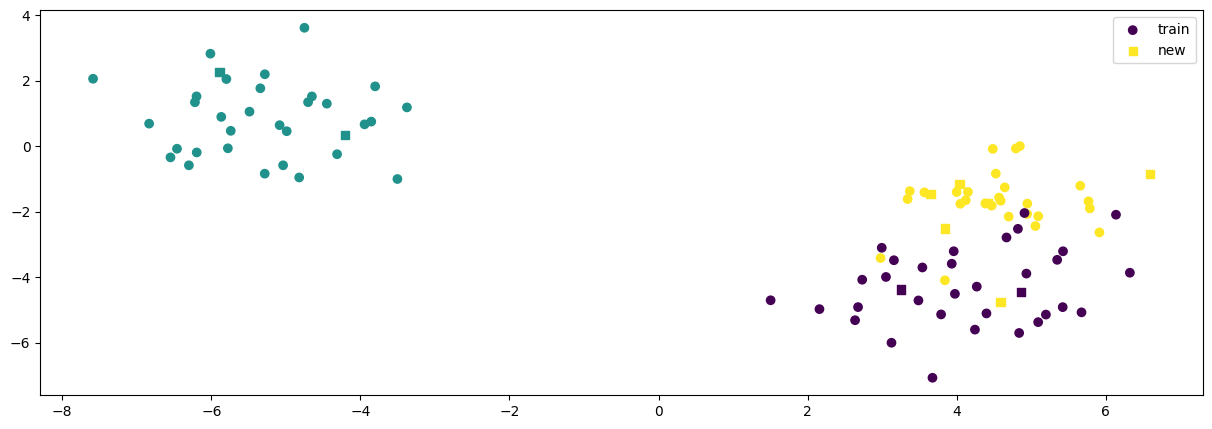

In [42]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]

plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

<div class="qst">

* Train and transform a classical PCA model over the training data (`X_train`), using both the implemented `KPCA` class using a linear kernel and the `PCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [43]:
from sklearn.decomposition import PCA

kernel = "linear"
n_components=1

model_my = KPCA(n_components=n_components, kernel=kernel)
model_sk = PCA(n_components=n_components)

# Training of the models (complete).
model_my.fit(X_train)
model_sk.fit(X_train)

X_transformed_my = model_my.transform(X_new)
X_transformed_sk = model_sk.transform(X_new)

# Comparative of the eigenvectors (complete).
print("Eigenvectors (KPCA with linear kernel):")
print(model_my.alphas_)

print("Eigenvectors (PCA from sklearn):")
print(model_sk.components_)

# Comparative of the projections (complete).
print("Projections from the new data (KPCA with linear kernel):")
print(X_transformed_my)

print("Projections from the new data (PCA from sklearn):")
print(X_transformed_sk)

Eigenvectors (KPCA with linear kernel):
[[-0.00170185]
 [-0.00144365]
 [ 0.00315548]
 [-0.00089386]
 [-0.00149731]
 [ 0.00330584]
 [-0.00195384]
 [-0.00101385]
 [-0.00112589]
 [-0.00150643]
 [ 0.00316604]
 [-0.00124488]
 [ 0.00412394]
 [-0.00245382]
 [ 0.00272538]
 [ 0.00323974]
 [-0.00222184]
 [-0.00108122]
 [-0.00136759]
 [ 0.0025524 ]
 [-0.00135725]
 [-0.00138989]
 [-0.0009797 ]
 [ 0.00240797]
 [ 0.00310645]
 [ 0.00323024]
 [ 0.0028349 ]
 [-0.00126455]
 [ 0.00339847]
 [-0.00121293]
 [-0.00204988]
 [-0.00226901]
 [-0.00157906]
 [-0.00179196]
 [-0.00203722]
 [ 0.00329657]
 [ 0.00310401]
 [-0.00159641]
 [-0.00124917]
 [-0.00213565]
 [ 0.00264391]
 [ 0.00227101]
 [ 0.00270032]
 [-0.00115289]
 [-0.00123387]
 [-0.00141198]
 [-0.00198297]
 [ 0.00249343]
 [-0.00164926]
 [ 0.00303186]
 [ 0.00321436]
 [ 0.00287044]
 [ 0.00347081]
 [-0.00196091]
 [ 0.00241332]
 [ 0.00317956]
 [-0.00103468]
 [ 0.00284394]
 [-0.00141369]
 [-0.00121385]
 [-0.00196446]
 [-0.00167622]
 [-0.0007027 ]
 [ 0.00195203]


<div class="qst">

* Train and transform a Kernel PCA model using a RBF kernel over the training data (`X_train`), calling both the implemented `KPCA` class and the `KernelPCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [44]:
from sklearn.decomposition import KernelPCA

kernel = 'rbf'
n_components=1

# Model definition (complete).
model_my = KPCA(n_components=n_components, kernel=kernel)
model_sk = KernelPCA(n_components=n_components, kernel=kernel)

# Training of the models (complete).
model_my.fit(X_train)
model_sk.fit(X_train)

X_transformed_my = model_my.transform(X_new)
X_transformed_sk = model_sk.transform(X_new)

# Comparative of the eigenvectors (complete).
print("Eigenvectors (KPCA with rbf kernel):")
print(model_my.alphas_)

print("Eigenvectors (PCA from sklearn):")
print(model_sk.eigenvectors_)

# Comparative of the projections (complete).
print("Projections from the new data (KPCA with rbf kernel):")
print(X_transformed_my)

print("Projections from the new data (PCA from sklearn):")
print(X_transformed_sk)

Eigenvectors (KPCA with rbf kernel):
[[-0.0184179 ]
 [ 0.00910838]
 [-0.02358837]
 [ 0.02551654]
 [-0.00175825]
 [-0.0264137 ]
 [-0.00204582]
 [-0.01401477]
 [ 0.01250552]
 [-0.01798586]
 [-0.03037332]
 [ 0.0478971 ]
 [-0.01174927]
 [-0.01280582]
 [-0.02981593]
 [-0.01061907]
 [-0.0156769 ]
 [-0.00757329]
 [ 0.05226135]
 [-0.01983528]
 [-0.00793499]
 [ 0.04714369]
 [ 0.03168654]
 [-0.02331573]
 [-0.03492479]
 [-0.03445958]
 [-0.03176046]
 [-0.01538157]
 [-0.02580751]
 [-0.01631257]
 [ 0.00832775]
 [-0.01561668]
 [-0.01396165]
 [ 0.02747859]
 [ 0.01491123]
 [-0.02368444]
 [-0.0357229 ]
 [ 0.05138531]
 [ 0.01163239]
 [ 0.01947637]
 [-0.0251263 ]
 [-0.01821324]
 [-0.02293298]
 [ 0.04315734]
 [ 0.04637638]
 [ 0.05251393]
 [-0.00986   ]
 [-0.02002611]
 [ 0.04996146]
 [-0.03148758]
 [-0.02509221]
 [-0.03535701]
 [-0.0280933 ]
 [ 0.03040942]
 [-0.02467343]
 [-0.02802358]
 [-0.00274473]
 [-0.03012773]
 [ 0.05297554]
 [ 0.04614166]
 [-0.01710318]
 [ 0.04103067]
 [-0.01117518]
 [-0.01234853]
 [ 

## Comparing linear kernel against Gaussian kernel

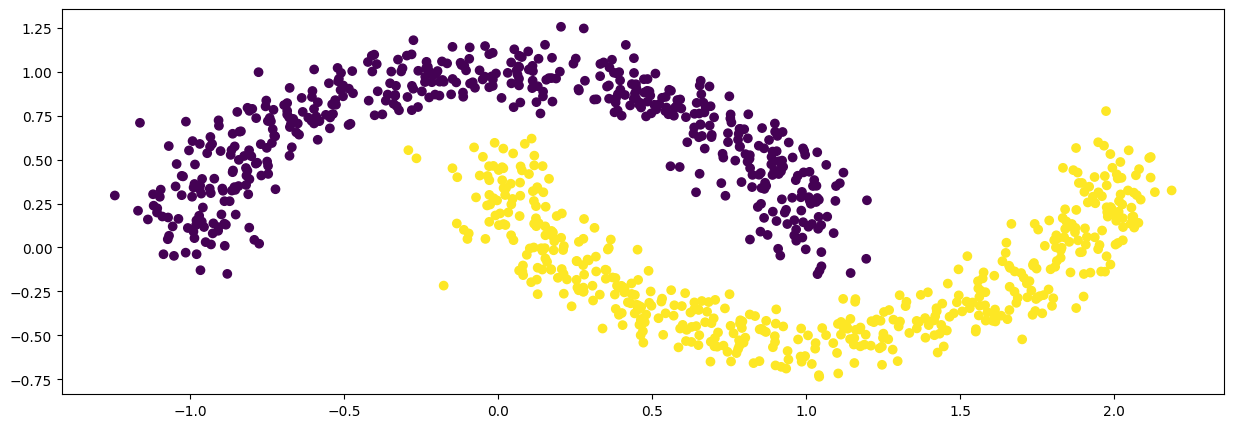

In [45]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=1e-1, random_state=seed)

plt.scatter(X[:,0], X[:,1],c=y)

<div class="qst">

* Using the implemented class `KPCA` compare the result of transforming the above dataset using a linear kernel and an RBF one (looking for an appropriated hyperparameter `gamma` value).
* Is there some model able to properly project the classes separately?
</div>

The AUC using linear kernel is: 0.1478365384615385
The AUC using rbf kernel (without adjusting gamma) is: 0.1346153846153846


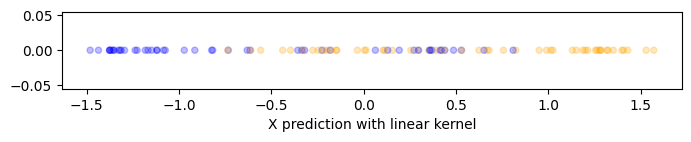

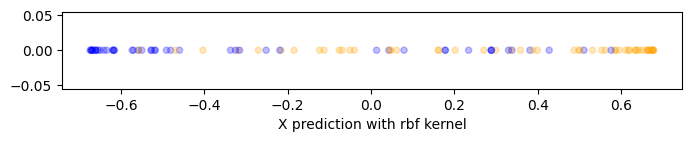

The best value for gamma is: 14.14
The AUC using rbf kernel (using the best gamma) is: 0.9884


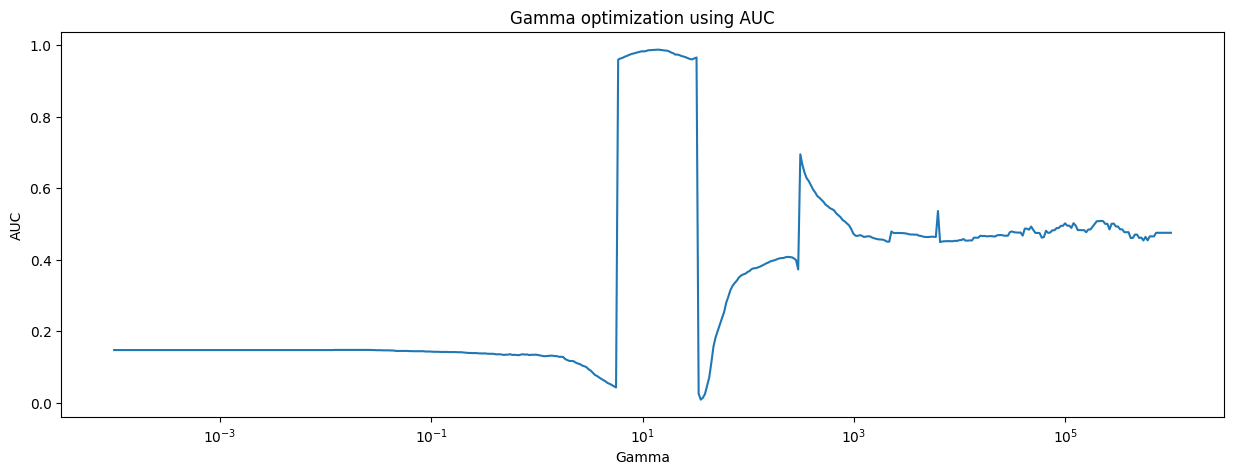

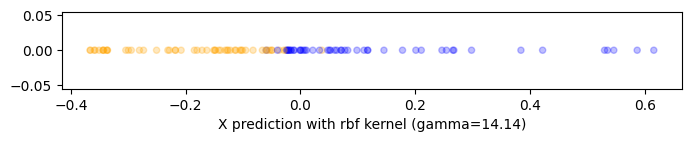

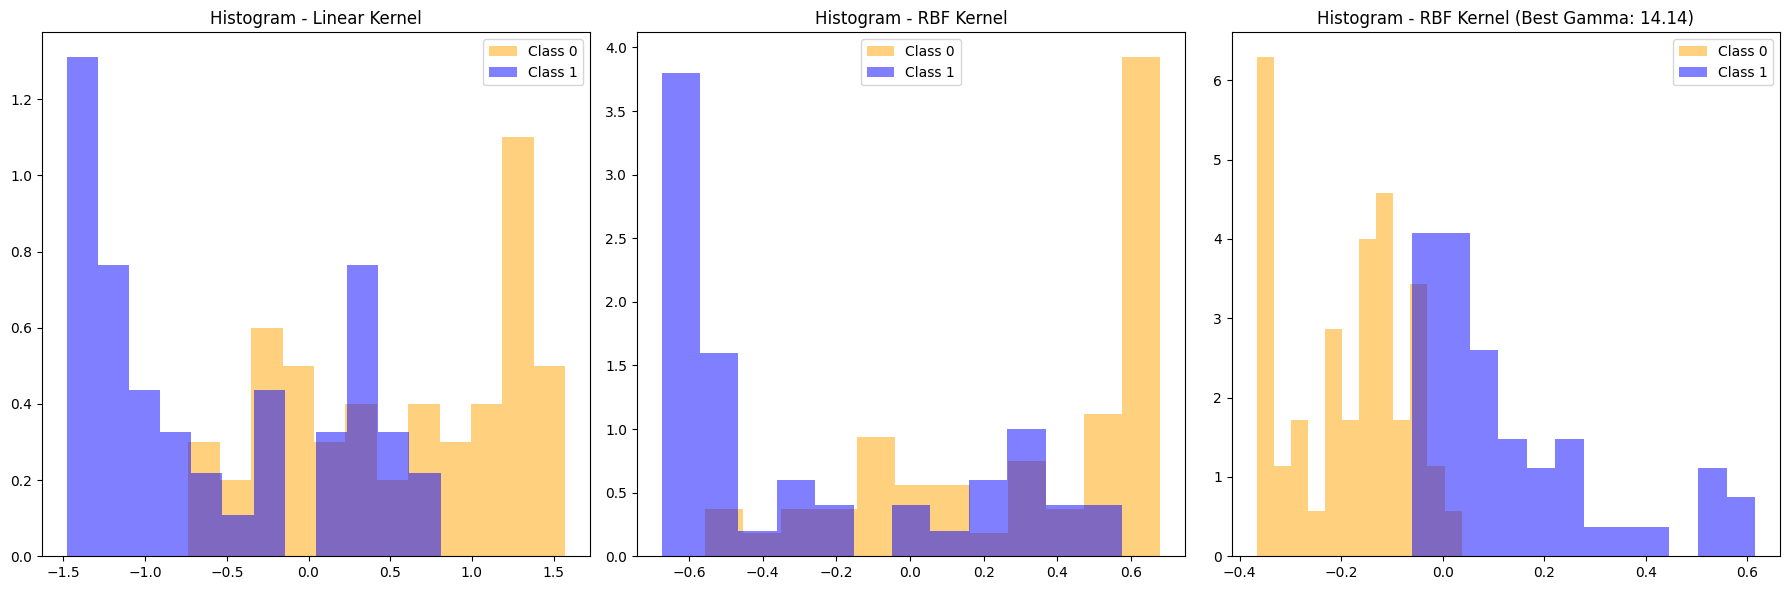

In [46]:
from sklearn.metrics import roc_auc_score

n_components=1
X_train = X[:int(X.shape[0]*0.9),:]; y_train=y[:int(y.shape[0]*0.9)]
X_new = X[int(X.shape[0]*0.9):,:]; y_new=y[int(y.shape[0]*0.9):]

# Model definition (complete).
model_linear = KPCA(n_components=n_components, kernel='linear')
model_rbf = KPCA(n_components=n_components, kernel='rbf')

# Training of the models (complete).
model_linear.fit(X_train)
model_rbf.fit(X_train)

X_transformed_linear = model_linear.transform(X_new)
X_transformed_rbf = model_rbf.transform(X_new)

# Calculation of AUC for the models
auc_linear = roc_auc_score(y_new, X_transformed_linear)
auc_rbf = roc_auc_score(y_new, X_transformed_rbf)
print(f'The AUC using linear kernel is: {auc_linear}')
print(f'The AUC using rbf kernel (without adjusting gamma) is: {auc_rbf}')

# Scatter plots for the classification results
plt.figure(figsize=(8, 1))
colors = np.where(y_new == 0, 'orange', 'blue')
plt.scatter(X_transformed_linear, np.zeros_like(X_transformed_linear), c=colors, s=20, alpha=0.25)
plt.xlabel('X prediction with linear kernel')
plt.show()

plt.figure(figsize=(8, 1))
plt.scatter(X_transformed_rbf, np.zeros_like(X_transformed_rbf), c=colors, s=20, alpha=0.25)
plt.xlabel('X prediction with rbf kernel')
plt.show()

# Optimization of gamma
gamma_range = np.logspace(-4, 6, 500)
scores = []

# Loop for every gamma value
for gamma in gamma_range:

    # Model definition
    model_rbf_g = KernelPCA(n_components=1, kernel='rbf', gamma=gamma)
    
    # Training of the models
    model_rbf_g.fit(X_train)
    X_transformed_rbf_g = model_rbf_g.transform(X_new)
    
    # Calculation of AUC
    auc = roc_auc_score(y_new, X_transformed_rbf_g)
    
    # Save the result
    scores.append(auc)

# Find best gamma
best_gamma = gamma_range[np.argmax(scores)]
best_auc = np.max(scores)

print(f"The best value for gamma is: {np.round(best_gamma,2)}")
print(f"The AUC using rbf kernel (using the best gamma) is: {np.round(best_auc,4)}")

# Representing AUC vs gamma
plt.plot(gamma_range, scores)
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('AUC')
plt.title('Gamma optimization using AUC')
plt.show()

# Model definition and training for the best gamma
model_rbf_best = KernelPCA(n_components=1, kernel='rbf', gamma=best_gamma)
model_rbf_best.fit(X_train)
X_transformed_rbf_best = model_rbf_best.transform(X_new)

# Scatter plot for the classification results
plt.figure(figsize=(8, 1))
plt.scatter(X_transformed_rbf_best, np.zeros_like(X_transformed_rbf_best), c=colors, s=20, alpha=0.25)
plt.xlabel(f'X prediction with rbf kernel (gamma={np.round(best_gamma,2)})')
plt.show()

# Histograms to better see the classification
plt.figure(figsize=(18, 6))

# Histogram for the linear kernel
plt.subplot(1, 3, 1)
plt.hist(X_transformed_linear[y_new == 0], bins=12, alpha=0.5, label='Class 0', color='orange', density=True)
plt.hist(X_transformed_linear[y_new == 1], bins=12, alpha=0.5, label='Class 1', color='blue', density=True)
plt.title('Histogram - Linear Kernel')
plt.legend()

# Histogram for the rbf kernel
plt.subplot(1, 3, 2)
plt.hist(X_transformed_rbf[y_new == 0], bins=12, alpha=0.5, label='Class 0', color='orange', density=True)
plt.hist(X_transformed_rbf[y_new == 1], bins=12, alpha=0.5, label='Class 1', color='blue', density=True)
plt.title('Histogram - RBF Kernel')
plt.legend()

#  Histogram for the best rbf kernel
plt.subplot(1, 3, 3)
plt.hist(X_transformed_rbf_best[y_new == 0], bins=12, alpha=0.5, label='Class 0', color='orange', density=True)
plt.hist(X_transformed_rbf_best[y_new == 1], bins=12, alpha=0.5, label='Class 1', color='blue', density=True)
plt.title(f'Histogram - RBF Kernel (Best Gamma: {np.round(best_gamma,2)})')
plt.legend()

plt.tight_layout()
plt.show()

As it can be seen, without any optimization, the models can distinguish between both classes some of the data points of the dataset. However, there are a lot of point that cannot be distinguish properly. This is shown with the AUC values which are very small meaning that the true positives or true negatives are not so well predicted and there are a lot of false positive and false negative results.

When the hyperparamter gamma is optimized, the results become much better, reaching values for the AUC very close to 1 which means that the model does better predicitons. We can consider that this model dos in fact properly project the classes separately and distinguish them, unlike the previous models.

We have used several methods to find the best value of the hyperparameter gamma (such as the distance betwee the mean of the classes, or this distance square) but the calculation of the ROC curve and the optimization of the AUC has provided the best results to finding the best model.